In [1]:
import cv2
import torch
import argparse
import glob
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
class SuperPointNet(torch.nn.Module):
  
  """ Pytorch definition of SuperPoint Network. """

  def __init__(self):

    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256

    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)

    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)

    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):

    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))

    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)

    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    
    return semi, desc

In [3]:
class SuperPointFrontend:
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh, cuda=False):
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh
        self.cell = 8
        self.border_remove = 4
        self.net = SuperPointNet()
        if self.cuda:
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
            self.net.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):
        grid = np.zeros((H, W)).astype(int)
        inds = np.zeros((H, W)).astype(int)
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int)
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        for i, rc in enumerate(rcorners.T):
            grid[rc[1], rc[0]] = 1
            inds[rc[1], rc[0]] = i
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        count = 0
        for i, rc in enumerate(rcorners.T):
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1:
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 and img.dtype == np.float32
        H, W = img.shape
        inp = torch.from_numpy(img.reshape(1, 1, H, W))
        if self.cuda:
            inp = inp.cuda()
        with torch.no_grad():
            semi, coarse_desc = self.net.forward(inp)
        semi = semi.data.cpu().numpy().squeeze()
        dense = np.exp(semi)
        dense = dense / (np.sum(dense, axis=0)+.00001)
        nodust = dense[:-1, :, :]
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = nodust.transpose(1, 2, 0)
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [H, W])
        xs, ys = np.where(heatmap >= self.conf_thresh)
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        pts = np.zeros((3, len(xs)))
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heatmap[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist)
        inds = np.argsort(pts[2, :])
        pts = pts[:, inds[::-1]]
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        pts = pts[:, ~(toremoveW | toremoveH)]
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (W / 2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (H / 2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous().view(1, 1, -1, 2).float()
            if self.cuda:
                samp_pts = samp_pts.cuda()
            desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
        return pts, desc, heatmap

    def nn_match_two_way(self, desc1, desc2, nn_thresh):
        if desc1 is None or desc2 is None or desc1.shape[1] == 0 or desc2.shape[1] == 0:
            return np.zeros((3, 0))
        dmat = np.dot(desc1.T, desc2)
        dmat = np.sqrt(2 - 2 * np.clip(dmat, -1, 1))
        idx = np.argmin(dmat, axis=1)
        scores = dmat[np.arange(dmat.shape[0]), idx]
        keep = scores < nn_thresh
        idx2 = np.argmin(dmat, axis=0)
        keep_bi = np.arange(len(idx)) == idx2[idx]
        keep = np.logical_and(keep, keep_bi)
        m_idx1 = np.arange(desc1.shape[1])[keep]
        m_idx2 = idx[keep]
        matches = np.zeros((3, int(np.sum(keep))))
        matches[0, :] = m_idx1
        matches[1, :] = m_idx2
        matches[2, :] = scores[keep]
        return matches


In [4]:
fe = SuperPointFrontend(
    weights_path="superpoint_v1.pth",  
    nms_dist=4,
    conf_thresh=0.015,
    nn_thresh=0.7,
    cuda=torch.cuda.is_available()
)


SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-00.jpg


C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-01.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-02.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-03.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-04.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-05.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-06.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-07.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-08.jpg
SYS809_projet2021_sequences1/legumesA-00.jpg SYS809_projet2021_sequences1/legumesB-09.jpg
SYS809_projet2021_sequences1/legumesA-01.jpg SYS809_projet2021_sequences1/legumesB-00.jpg
SYS809_projet2021_sequences1/legumesA-01.jpg SYS809_projet2021_sequences1/legumesB-01.jpg
SYS809_pro

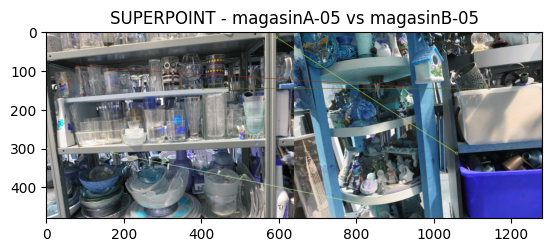

In [ ]:
scene_aleatoire = random.choice(["legumes", "neige", "cour", "magasin"])
indice_aleatoire = random.randint(0, 10)

for scene in ["legumes", "neige", "magasin","cour" ]:
    if scene == "magasin":
        max_i = 12
        max_j = 11
    else:
        max_i = 10
        max_j = 10

    for i in range(0, max_i): 
        image_A = f"SYS809_projet2021_sequences1/{scene}A-{str(i).zfill(2)}.jpg"

        for j in range(0, max_j):  
            image_B = f"SYS809_projet2021_sequences1/{scene}B-{str(j).zfill(2)}.jpg"
            print(image_A, image_B)

            imgA = cv2.imread(image_A)
            imgB = cv2.imread(image_B)
        

            gris_A = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
            gris_B = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

            
            pts_A, desc_A, _ = fe.run(gris_A)
            pts_B, desc_B, _ = fe.run(gris_B)

          
            kpts_A = pts_A.T 
            kpts_B = pts_B.T 

            
            np.save(image_A + ".superpoint.kpts.npy", kpts_A)
            np.save(image_B + ".superpoint.kpts.npy", kpts_B)


          
            if desc_A is not None and desc_B is not None:
                matches = fe.nn_match_two_way(desc_A, desc_B, 0.7)

                
                kpA = [cv2.KeyPoint(float(pts_A[0, k]), float(pts_A[1, k]), 1) for k in range(pts_A.shape[1])]
                kpB = [cv2.KeyPoint(float(pts_B[0, k]), float(pts_B[1, k]), 1) for k in range(pts_B.shape[1])]

                
                good_matches = []
                for idx in range(matches.shape[1]):
                    i_ = int(matches[0, idx])
                    j_ = int(matches[1, idx])
                    d_ = float(matches[2, idx])
                    good_matches.append(cv2.DMatch(_queryIdx=i_, _trainIdx=j_, _distance=d_))

                
                matched_img = cv2.drawMatches(imgA, kpA, imgB, kpB, good_matches[:20], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        if scene == scene_aleatoire and i == indice_aleatoire:
             
             plt.figure()
             plt.title(f"SUPERPOINT - {scene}A-{str(i).zfill(2)} vs {scene}B-{str(i).zfill(2)}")
             plt.imshow(matched_img)
               


In [7]:
matrices_superpoint = {}

Scène : legumes - A0 vs B0 ➡️ Erreur = 0
Scène : legumes - A1 vs B1 ➡️ Erreur = 0
Scène : legumes - A2 vs B2 ➡️ Erreur = 0
Scène : legumes - A3 vs B3 ➡️ Erreur = 0
Scène : legumes - A4 vs B4 ➡️ Erreur = 0
Scène : legumes - A5 vs B5 ➡️ Erreur = 0
Scène : legumes - A6 vs B6 ➡️ Erreur = 0
Scène : legumes - A7 vs B7 ➡️ Erreur = 0
Scène : legumes - A8 vs B8 ➡️ Erreur = 0
Scène : legumes - A9 vs B9 ➡️ Erreur = 0
legumes - Temps total : 26.97s - Temps moyen par comparaison : 0.2697s


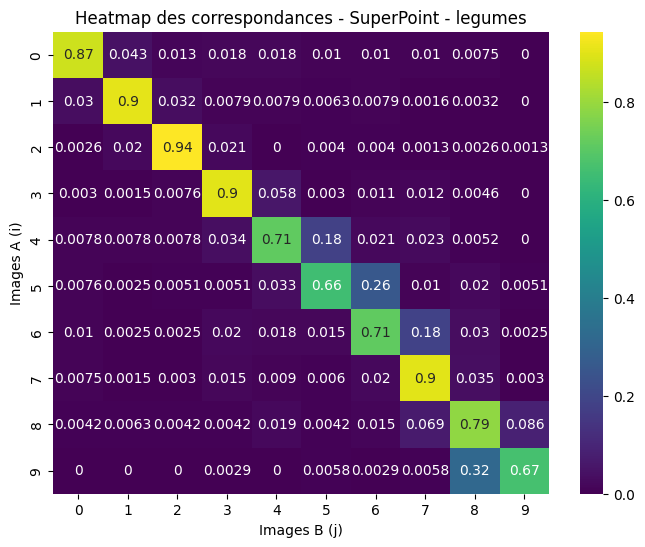

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : neige - A0 vs B0 ➡️ Erreur = 0
Scène : neige - A1 vs B1 ➡️ Erreur = 0
Scène : neige - A2 vs B2 ➡️ Erreur = 0
Scène : neige - A3 vs B3 ➡️ Erreur = 0
Scène : neige - A4 vs B4 ➡️ Erreur = 0
Scène : neige - A5 vs B5 ➡️ Erreur = 0
Scène : neige - A6 vs B6 ➡️ Erreur = 0
Scène : neige - A7 vs B7 ➡️ Erreur = 0
Scène : neige - A8 vs B8 ➡️ Erreur = 0
Scène : neige - A9 vs B9 ➡️ Erreur = 0
neige - Temps total : 29.38s - Temps moyen par comparaison : 0.2938s


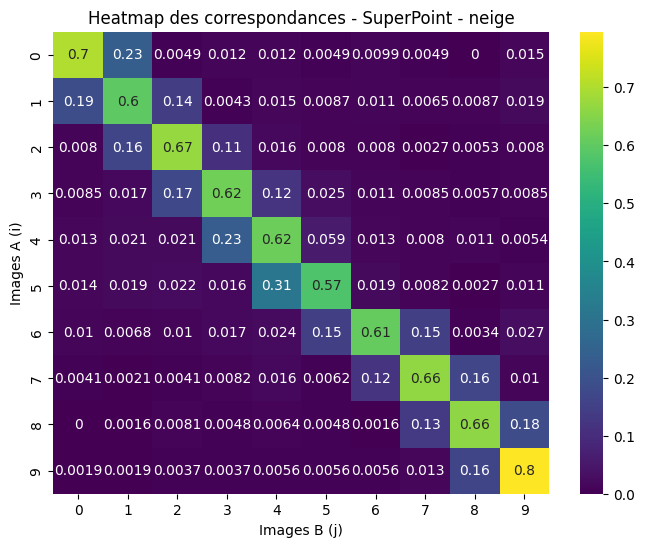

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : magasin - A0 vs B0 ➡️ Erreur = 0
Scène : magasin - A1 vs B1 ➡️ Erreur = 0
Scène : magasin - A2 vs B2 ➡️ Erreur = 0
Scène : magasin - A3 vs B3 ➡️ Erreur = 0
Scène : magasin - A4 vs B3 ➡️ Erreur = 1
Scène : magasin - A5 vs B4 ➡️ Erreur = 1
Scène : magasin - A6 vs B5 ➡️ Erreur = 1
Scène : magasin - A7 vs B6 ➡️ Erreur = 1
Scène : magasin - A8 vs B7 ➡️ Erreur = 1
Scène : magasin - A9 vs B8 ➡️ Erreur = 1
Scène : magasin - A10 vs B9 ➡️ Erreur = 1
Scène : magasin - A11 vs B10 ➡️ Erreur = 1
magasin - Temps total : 39.90s - Temps moyen par comparaison : 0.3022s


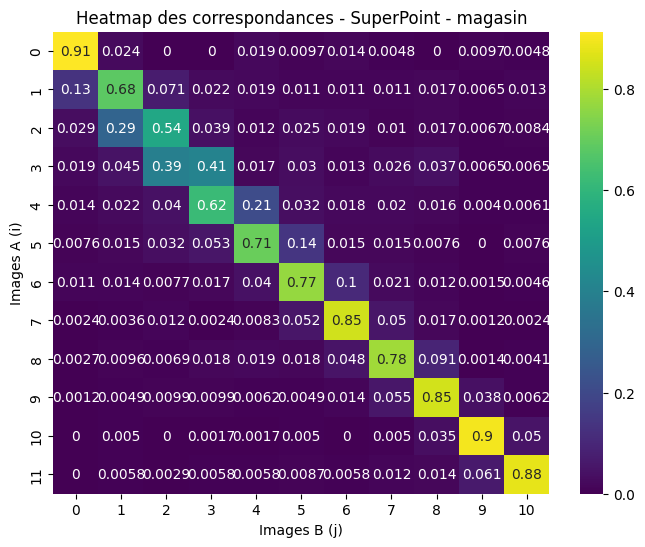

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : cour - A0 vs B0 ➡️ Erreur = 0
Scène : cour - A1 vs B0 ➡️ Erreur = 1
Scène : cour - A2 vs B1 ➡️ Erreur = 1
Scène : cour - A3 vs B6 ➡️ Erreur = 3
Scène : cour - A4 vs B1 ➡️ Erreur = 3
Scène : cour - A5 vs B7 ➡️ Erreur = 2
Scène : cour - A6 vs B6 ➡️ Erreur = 0
Scène : cour - A7 vs B0 ➡️ Erreur = 7
Scène : cour - A8 vs B5 ➡️ Erreur = 3
Scène : cour - A9 vs B1 ➡️ Erreur = 8
cour - Temps total : 22.47s - Temps moyen par comparaison : 0.2247s


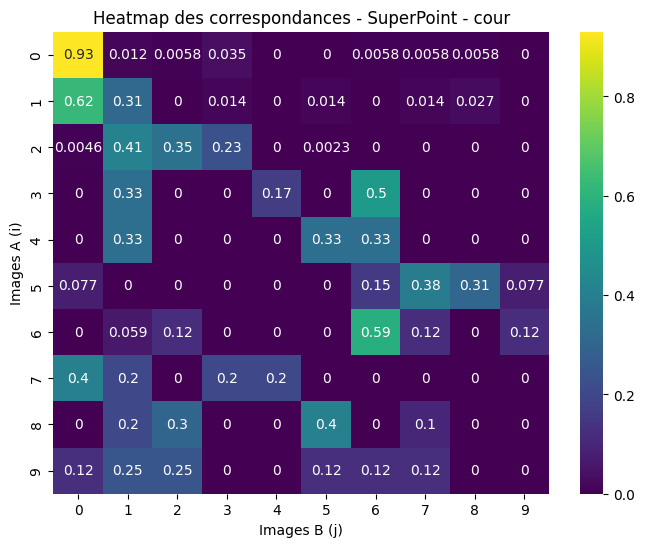

In [ ]:
matrices_superpoint = {}

for scene in ["legumes", "neige", "magasin", "cour"]:
    if scene == "magasin":
        max_i = 12
        max_j = 11
    else:
        max_i = 10
        max_j = 10

    matrice_scores = np.zeros((max_i, max_j))

    start_time = time.time()

    for i in range(0, max_i):  # A{i}
        image_A = f"SYS809_projet2021_sequences1/{scene}A-{str(i).zfill(2)}.jpg"
        imgA = cv2.imread(image_A)
        gris_A = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.
        pts_A, des_A, _ = fe.run(gris_A)  # fe = SuperPointFrontend(...)

        scores = []

        for j in range(0, max_j):  # B{j}
            image_B = f"SYS809_projet2021_sequences1/{scene}B-{str(j).zfill(2)}.jpg"
            imgB = cv2.imread(image_B)
            gris_B = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.
            pts_B, des_B, _ = fe.run(gris_B)

            matches = fe.nn_match_two_way(des_A, des_B, nn_thresh=0.7)
            scores.append(matches.shape[1])
            matrice_scores[i, j] = matches.shape[1]

        j_max = np.argmax(scores)
        erreur = abs(i - j_max)

        if np.sum(matrice_scores[i, :]) > 0:
            matrice_scores[i, :] = matrice_scores[i, :] / np.sum(matrice_scores[i, :])

        print(f"Scène : {scene} - A{i} vs B{j_max} ➡️ Erreur = {erreur}")

    end_time = time.time()
    duree_totale = end_time - start_time
    temps_moyen = duree_totale / (max_i * max_j)
    print(f"{scene} - Temps total : {duree_totale:.2f}s - Temps moyen par comparaison : {temps_moyen:.4f}s")

    matrices_superpoint[scene] = matrice_scores

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_scores, annot=True, cmap="viridis")
    plt.xlabel("Images B (j)")
    plt.ylabel("Images A (i)")
    plt.title(f"Heatmap des correspondances - SuperPoint - {scene}")
    plt.show()


In [9]:
for scene in ["legumes", "neige", "magasin", "cour"]:
    matrice = matrices_superpoint[scene]  

    erreurs = []
    for i in range(matrice.shape[0]):
        j_max = np.argmax(matrice[i, :])
        erreur = abs(i - j_max)
        erreurs.append(erreur)
    
    print(f"{scene} - Erreur moyenne Superpoint : {np.mean(erreurs):.2f}")


legumes - Erreur moyenne Superpoint : 0.00
neige - Erreur moyenne Superpoint : 0.00
magasin - Erreur moyenne Superpoint : 0.67
cour - Erreur moyenne Superpoint : 2.80


In [5]:
dossier = "SYS809_projet2021_sequences1"
scene = "neige" 
max_index = 10
taille_superpoint = (640, 480)



i_cible = random.randint(1, max_index - 2)
img_cible_path = f"{dossier}/{scene}A-{str(i_cible).zfill(2)}.jpg"
img_cible = cv2.imread(img_cible_path)
img_cible = cv2.resize(img_cible, taille_superpoint)
img_cible_gray = cv2.cvtColor(img_cible, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

print(f" Image cible : {scene}A-{str(i_cible).zfill(2)}.jpg")



pts_cible, des_cible, _ = fe.run(img_cible_gray)


images_A, indices_A = [], []
images_B, indices_B = [], []

for i in range(max_index):
    if i != i_cible:
        path_A = f"{dossier}/{scene}A-{str(i).zfill(2)}.jpg"
        img_A = cv2.imread(path_A)
        if img_A is not None:
            img_A = cv2.resize(img_A, taille_superpoint)
            images_A.append(img_A)
            indices_A.append(i)

        path_B = f"{dossier}/{scene}B-{str(i).zfill(2)}.jpg"
        img_B = cv2.imread(path_B)
        if img_B is not None:
            img_B = cv2.resize(img_B, taille_superpoint)
            images_B.append(img_B)
            indices_B.append(i)


def score_similarite_superpoint(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    pts1, des1, _ = fe.run(img1_gray)
    pts2, des2, _ = fe.run(img2_gray)

    if des_cible is not None and des1 is not None and des2 is not None:
        matches1 = fe.nn_match_two_way(des_cible, des1, 0.7)
        matches2 = fe.nn_match_two_way(des_cible, des2, 0.7)

        score1 = matches1.shape[1] if matches1.shape[1] > 0 else 1e-6
        score2 = matches2.shape[1] if matches2.shape[1] > 0 else 1e-6

        return - (score1 + score2)  
    else:
        return 1e6



scores_A, paires_A = [], []

for j in range(len(images_A) - 1):
    i1, i2 = indices_A[j], indices_A[j + 1]
    score = score_similarite_superpoint(images_A[j], images_A[j + 1])
    scores_A.append(score)
    paires_A.append((i1, i2))



scores_B, paires_B = [], []

for j in range(len(images_B) - 1):
    i1, i2 = indices_B[j], indices_B[j + 1]
    score = score_similarite_superpoint(images_B[j], images_B[j + 1])
    scores_B.append(score)
    paires_B.append((i1, i2))



def eval_result(scores, paires, i_cible):
    if scores:
        idx = np.argmin(scores)
        j1, j2 = paires[idx]
        if j1 < i_cible < j2:
            return 0, j1, j2
        else:
            return min(abs(i_cible - j1), abs(i_cible - j2)), j1, j2
    return None, None, None

erreur_A, j1_A, j2_A = eval_result(scores_A, paires_A, i_cible)
erreur_B, j1_B, j2_B = eval_result(scores_B, paires_B, i_cible)


print("\n Résultat SuperPoint - Insertion logique (A et B masqués) :")
print(f"  Position réelle de l’image cible : A-{str(i_cible).zfill(2)}")

if erreur_A is not None:
    print(f" Insertion estimée dans A : entre A-{str(j1_A).zfill(2)} et A-{str(j2_A).zfill(2)}  Erreur (A) = {erreur_A}")
else:
    print(" Insertion dans A : impossible à estimer")

if erreur_B is not None:
    print(f" Insertion estimée dans B : entre B-{str(j1_B).zfill(2)} et B-{str(j2_B).zfill(2)}  Erreur (B) = {erreur_B}")
else:
    print(" Insertion dans B : impossible à estimer")


 Image cible : neigeA-08.jpg


C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(



 Résultat SuperPoint - Insertion logique (A et B masqués) :
  Position réelle de l’image cible : A-08
 Insertion estimée dans A : entre A-07 et A-09  Erreur (A) = 0
 Insertion estimée dans B : entre B-07 et B-09  Erreur (B) = 0


SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-00.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-01.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-02.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-03.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-04.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-05.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-06.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-07.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-08.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-09.png
SYS809_projet2025_sequences2/brainA-00.png SYS809_projet2025_sequences2/brainB-10.png
SYS809_projet2025_sequences2/brainA-01.png SYS809_proj

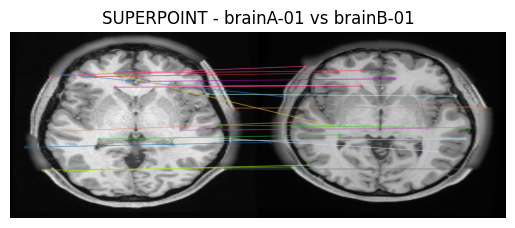

SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-00.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-01.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-02.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-03.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-04.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-05.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-06.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-07.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-08.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-09.png
SYS809_projet2025_sequences2/brainA-02.png SYS809_projet2025_sequences2/brainB-10.png
SYS809_projet2025_sequences2/brainA-03.png SYS809_proj

In [ ]:

scene_aleatoire = random.choice(["brain", "cuisine", "parc", "studio", "visages"])
indice_aleatoire = random.randint(0, 10)

taille_superpoint = (640, 480)  

for scene in ["brain", "cuisine", "parc", "studio", "visages"]:
    if scene == "brain":
        ext = ".png"
        max_i = 11
        max_j = 11
    else:
        ext = ".jpg"
        max_i = 10
        max_j = 10

    for i in range(0, max_i):  
        image_A = f"SYS809_projet2025_sequences2/{scene}A-{str(i).zfill(2)}{ext}"

        for j in range(0, max_j): 
            image_B = f"SYS809_projet2025_sequences2/{scene}B-{str(j).zfill(2)}{ext}"
            print(image_A, image_B)

            imgA = cv2.imread(image_A)
            imgB = cv2.imread(image_B)

            if imgA is None or imgB is None:
                continue  

           
            imgA = cv2.resize(imgA, taille_superpoint)
            imgB = cv2.resize(imgB, taille_superpoint)

          
            gris_A = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
            gris_B = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

           
            pts_A, desc_A, _ = fe.run(gris_A)
            pts_B, desc_B, _ = fe.run(gris_B)

           
            kpts_A = pts_A.T
            kpts_B = pts_B.T

            np.save(image_A + ".superpoint.kpts.npy", kpts_A)
            np.save(image_B + ".superpoint.kpts.npy", kpts_B)

            
            if desc_A is not None and desc_B is not None:
                matches = fe.nn_match_two_way(desc_A, desc_B, 0.7)

                kpA = [cv2.KeyPoint(float(pts_A[0, k]), float(pts_A[1, k]), 1) for k in range(pts_A.shape[1])]
                kpB = [cv2.KeyPoint(float(pts_B[0, k]), float(pts_B[1, k]), 1) for k in range(pts_B.shape[1])]

                good_matches = []
                for idx in range(matches.shape[1]):
                    i_ = int(matches[0, idx])
                    j_ = int(matches[1, idx])
                    d_ = float(matches[2, idx])
                    good_matches.append(cv2.DMatch(_queryIdx=i_, _trainIdx=j_, _distance=d_))

                matched_img = cv2.drawMatches(imgA, kpA, imgB, kpB, good_matches[:20], None,
                                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                
        if scene == scene_aleatoire and i == indice_aleatoire:
            
            plt.figure()
            plt.title(f"SUPERPOINT - {scene}A-{str(i).zfill(2)} vs {scene}B-{str(i).zfill(2)}")
            plt.imshow(matched_img)
            plt.axis("off")
            plt.show()


Scène : brain - A0 vs B0 ➡️ Erreur = 0
Scène : brain - A1 vs B1 ➡️ Erreur = 0
Scène : brain - A2 vs B2 ➡️ Erreur = 0
Scène : brain - A3 vs B0 ➡️ Erreur = 3
Scène : brain - A4 vs B4 ➡️ Erreur = 0
Scène : brain - A5 vs B5 ➡️ Erreur = 0
Scène : brain - A6 vs B6 ➡️ Erreur = 0
Scène : brain - A7 vs B7 ➡️ Erreur = 0
Scène : brain - A8 vs B8 ➡️ Erreur = 0
Scène : brain - A9 vs B2 ➡️ Erreur = 7
Scène : brain - A10 vs B10 ➡️ Erreur = 0
brain - Temps total : 32.85s - Temps moyen par comparaison : 0.2715s


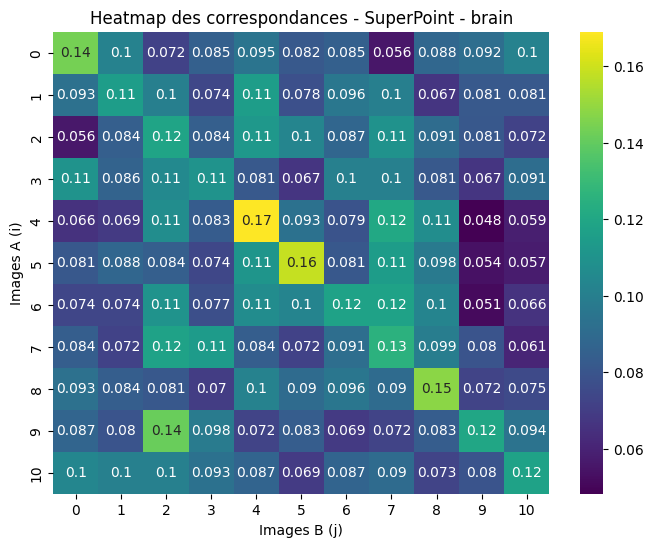

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : parc - A0 vs B0 ➡️ Erreur = 0
Scène : parc - A1 vs B1 ➡️ Erreur = 0
Scène : parc - A2 vs B2 ➡️ Erreur = 0
Scène : parc - A3 vs B3 ➡️ Erreur = 0
Scène : parc - A4 vs B4 ➡️ Erreur = 0
Scène : parc - A5 vs B5 ➡️ Erreur = 0
Scène : parc - A6 vs B6 ➡️ Erreur = 0
Scène : parc - A7 vs B7 ➡️ Erreur = 0
Scène : parc - A8 vs B9 ➡️ Erreur = 1
Scène : parc - A9 vs B9 ➡️ Erreur = 0
parc - Temps total : 31.72s - Temps moyen par comparaison : 0.3172s


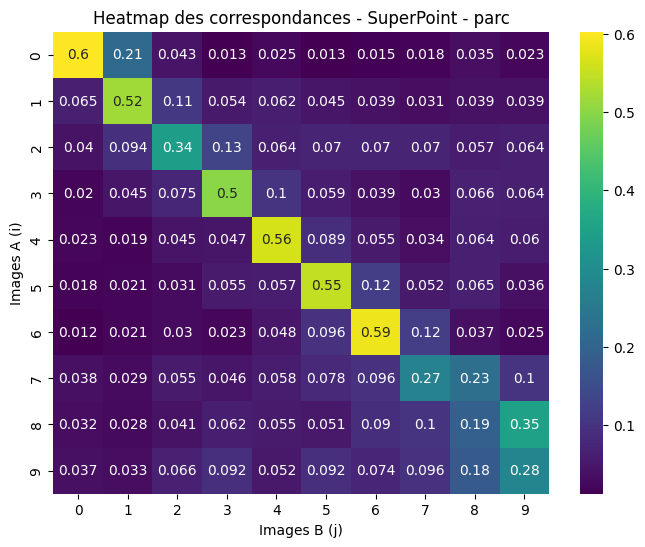

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : studio - A0 vs B0 ➡️ Erreur = 0
Scène : studio - A1 vs B1 ➡️ Erreur = 0
Scène : studio - A2 vs B2 ➡️ Erreur = 0
Scène : studio - A3 vs B3 ➡️ Erreur = 0
Scène : studio - A4 vs B4 ➡️ Erreur = 0
Scène : studio - A5 vs B5 ➡️ Erreur = 0
Scène : studio - A6 vs B6 ➡️ Erreur = 0
Scène : studio - A7 vs B7 ➡️ Erreur = 0
Scène : studio - A8 vs B8 ➡️ Erreur = 0
Scène : studio - A9 vs B9 ➡️ Erreur = 0
studio - Temps total : 30.75s - Temps moyen par comparaison : 0.3075s


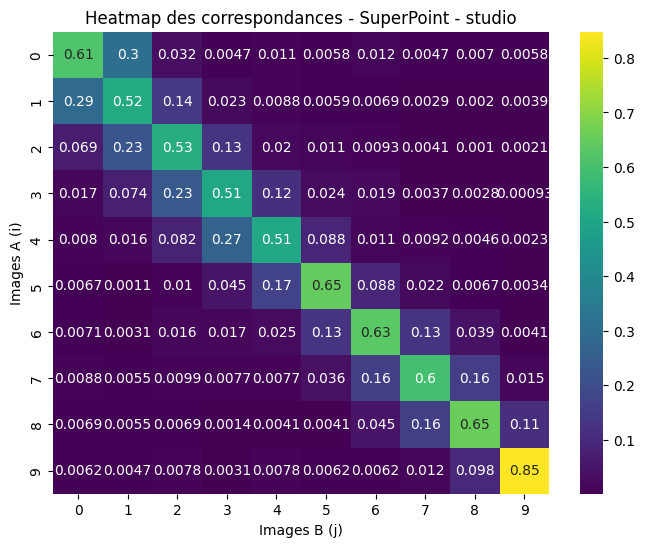

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : visages - A0 vs B0 ➡️ Erreur = 0
Scène : visages - A1 vs B1 ➡️ Erreur = 0
Scène : visages - A2 vs B2 ➡️ Erreur = 0
Scène : visages - A3 vs B3 ➡️ Erreur = 0
Scène : visages - A4 vs B4 ➡️ Erreur = 0
Scène : visages - A5 vs B5 ➡️ Erreur = 0
Scène : visages - A6 vs B6 ➡️ Erreur = 0
Scène : visages - A7 vs B7 ➡️ Erreur = 0
Scène : visages - A8 vs B8 ➡️ Erreur = 0
Scène : visages - A9 vs B9 ➡️ Erreur = 0
visages - Temps total : 29.27s - Temps moyen par comparaison : 0.2927s


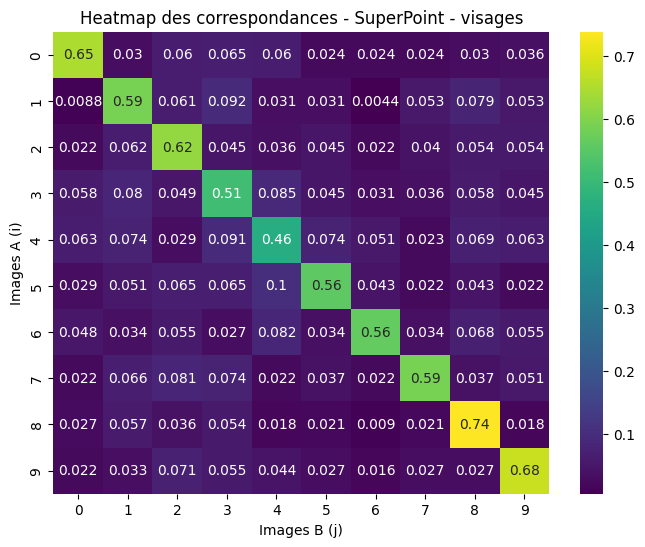

C:\Users\nembe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Scène : cuisine - A0 vs B0 ➡️ Erreur = 0
Scène : cuisine - A1 vs B0 ➡️ Erreur = 1
Scène : cuisine - A2 vs B2 ➡️ Erreur = 0
Scène : cuisine - A3 vs B3 ➡️ Erreur = 0
Scène : cuisine - A4 vs B4 ➡️ Erreur = 0
Scène : cuisine - A5 vs B5 ➡️ Erreur = 0
Scène : cuisine - A6 vs B7 ➡️ Erreur = 1
Scène : cuisine - A7 vs B8 ➡️ Erreur = 1
Scène : cuisine - A8 vs B9 ➡️ Erreur = 1
Scène : cuisine - A9 vs B0 ➡️ Erreur = 9
cuisine - Temps total : 29.69s - Temps moyen par comparaison : 0.2969s


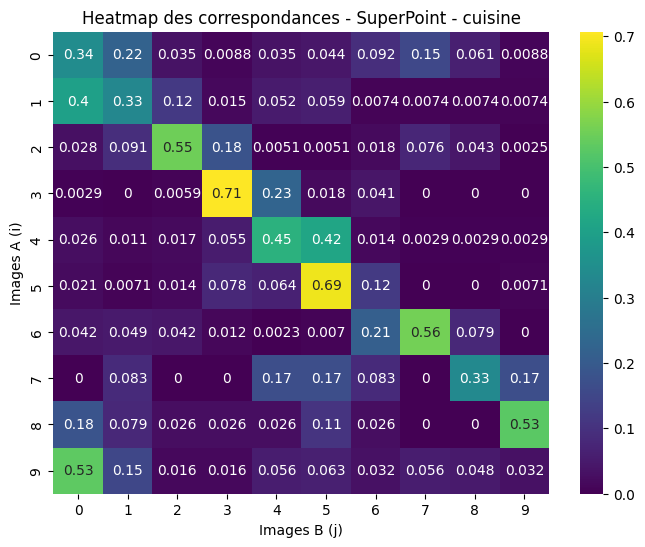

In [ ]:
matrices_superpoint = {}

taille_superpoint = (640, 480) 

for scene in ["brain", "parc", "studio", "visages", "cuisine"]:
    if scene == "brain":
        ext = ".png"
        max_i = 11
        max_j = 11
    else:
        ext = ".jpg"
        max_i = 10
        max_j = 10

    matrice_scores = np.zeros((max_i, max_j))

    start_time = time.time()

    for i in range(0, max_i):  
        image_A = f"SYS809_projet2025_sequences2/{scene}A-{str(i).zfill(2)}{ext}"
        imgA = cv2.imread(image_A)
        if imgA is None:
            continue

       
        imgA = cv2.resize(imgA, taille_superpoint)

        gris_A = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        pts_A, des_A, _ = fe.run(gris_A)

        scores = []

        for j in range(0, max_j):
            image_B = f"SYS809_projet2025_sequences2/{scene}B-{str(j).zfill(2)}{ext}"
            imgB = cv2.imread(image_B)
            if imgB is None:
                continue

        
            imgB = cv2.resize(imgB, taille_superpoint)

            gris_B = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
            pts_B, des_B, _ = fe.run(gris_B)

            
            if des_A is not None and des_B is not None:
                matches = fe.nn_match_two_way(des_A, des_B, nn_thresh=0.7)
                nb_matches = matches.shape[1]
            else:
                nb_matches = 0

            scores.append(nb_matches)
            matrice_scores[i, j] = nb_matches

        j_max = np.argmax(scores)
        erreur = abs(i - j_max)

        if np.sum(matrice_scores[i, :]) > 0:
            matrice_scores[i, :] = matrice_scores[i, :] / np.sum(matrice_scores[i, :])

        print(f"Scène : {scene} - A{i} vs B{j_max} ➡️ Erreur = {erreur}")

    end_time = time.time()
    duree_totale = end_time - start_time
    temps_moyen = duree_totale / (max_i * max_j)
    print(f"{scene} - Temps total : {duree_totale:.2f}s - Temps moyen par comparaison : {temps_moyen:.4f}s")

    matrices_superpoint[scene] = matrice_scores

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_scores, annot=True, cmap="viridis")
    plt.xlabel("Images B (j)")
    plt.ylabel("Images A (i)")
    plt.title(f"Heatmap des correspondances - SuperPoint - {scene}")
    plt.show()


In [15]:
for scene in ["brain", "parc", "studio", "visages", "cuisine"]:
    matrice = matrices_superpoint[scene]  

    erreurs = []
    for i in range(matrice.shape[0]):
        j_max = np.argmax(matrice[i, :])
        erreur = abs(i - j_max)
        erreurs.append(erreur)
    
    print(f"{scene} - Erreur moyenne Superpoint : {np.mean(erreurs):.2f}")


brain - Erreur moyenne Superpoint : 0.91
parc - Erreur moyenne Superpoint : 0.10
studio - Erreur moyenne Superpoint : 0.00
visages - Erreur moyenne Superpoint : 0.00
cuisine - Erreur moyenne Superpoint : 1.30


In [6]:
dossier = "SYS809_projet2025_sequences2"
scene = "studio" 
max_index = 10
taille_superpoint = (640, 480)



if scene == "brain":
    ext = ".png"
    max_index = 11
else:
    ext = ".jpg"



i_cible = random.randint(1, max_index - 2)
img_cible_path = f"{dossier}/{scene}A-{str(i_cible).zfill(2)}{ext}"
img_cible = cv2.imread(img_cible_path)
img_cible = cv2.resize(img_cible, taille_superpoint)
img_cible_gray = cv2.cvtColor(img_cible, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

print(f"Image cible : {scene}A-{str(i_cible).zfill(2)}{ext}")



pts_cible, des_cible, _ = fe.run(img_cible_gray)



images_A, indices_A = [], []
images_B, indices_B = [], []

for i in range(max_index):
    if i != i_cible:
        path_A = f"{dossier}/{scene}A-{str(i).zfill(2)}{ext}"
        path_B = f"{dossier}/{scene}B-{str(i).zfill(2)}{ext}"

        img_A = cv2.imread(path_A)
        img_B = cv2.imread(path_B)

        if img_A is not None:
            img_A = cv2.resize(img_A, taille_superpoint)
            images_A.append(img_A)
            indices_A.append(i)

        if img_B is not None:
            img_B = cv2.resize(img_B, taille_superpoint)
            images_B.append(img_B)
            indices_B.append(i)



def score_similarite_superpoint(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    pts1, des1, _ = fe.run(img1_gray)
    pts2, des2, _ = fe.run(img2_gray)

    if des_cible is not None and des1 is not None and des2 is not None:
        matches1 = fe.nn_match_two_way(des_cible, des1, 0.7)
        matches2 = fe.nn_match_two_way(des_cible, des2, 0.7)

        score1 = matches1.shape[1] if matches1.shape[1] > 0 else 1e-6
        score2 = matches2.shape[1] if matches2.shape[1] > 0 else 1e-6

        return - (score1 + score2)  
    else:
        return 1e6



scores_A, paires_A = [], []

for j in range(len(images_A) - 1):
    i1, i2 = indices_A[j], indices_A[j + 1]
    score = score_similarite_superpoint(images_A[j], images_A[j + 1])
    scores_A.append(score)
    paires_A.append((i1, i2))



scores_B, paires_B = [], []

for j in range(len(images_B) - 1):
    i1, i2 = indices_B[j], indices_B[j + 1]
    score = score_similarite_superpoint(images_B[j], images_B[j + 1])
    scores_B.append(score)
    paires_B.append((i1, i2))



def eval_result(scores, paires, i_cible):
    if scores:
        idx = np.argmin(scores)
        j1, j2 = paires[idx]
        if j1 < i_cible < j2:
            return 0, j1, j2
        else:
            return min(abs(i_cible - j1), abs(i_cible - j2)), j1, j2
    return None, None, None

erreur_A, j1_A, j2_A = eval_result(scores_A, paires_A, i_cible)
erreur_B, j1_B, j2_B = eval_result(scores_B, paires_B, i_cible)



print("\n Résultat SuperPoint - Insertion logique (A et B masqués) :")
print(f" Position réelle de l’image cible : A-{str(i_cible).zfill(2)}{ext}")

if erreur_A is not None:
    print(f" Insertion estimée dans A : entre A-{str(j1_A).zfill(2)} et A-{str(j2_A).zfill(2)} Erreur (A) = {erreur_A}")
else:
    print(" Insertion dans A : impossible à estimer")

if erreur_B is not None:
    print(f" Insertion estimée dans B : entre B-{str(j1_B).zfill(2)} et B-{str(j2_B).zfill(2)}  Erreur (B) = {erreur_B}")
else:
    print(" Insertion dans B : impossible à estimer")


Image cible : studioA-03.jpg

 Résultat SuperPoint - Insertion logique (A et B masqués) :
 Position réelle de l’image cible : A-03.jpg
 Insertion estimée dans A : entre A-02 et A-04 Erreur (A) = 0
 Insertion estimée dans B : entre B-02 et B-04  Erreur (B) = 0
